In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

#### Обозначения:

#### p - глубина истории, сколько измерений назад учитываем в моделях

#### h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

### Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с горизонт прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" . Учитывать только глубину истории при p=3

### Оцените ошибку модели из п.1 .

### Сделайте вывод о том, как изменилась ошибка модели по значениям h.

In [2]:
# Функции сглаживания, сплита ряда данных и вычисления ошибки

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#Загрузка данных
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head(3)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0


In [4]:
#Описание данных
data.describe(include='all').transpose().round()

#Пропусков,пропусков, отрицательных значений нет

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,145374,24,19:00:00,6058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PJME_MW,145374,NaN,NaN,NaN,32079.8,6464.17,14544,27573,31421,35648.8,62009
year,145374,NaN,NaN,NaN,2009.8,4.79189,2002,2006,2010,2014,2018
month,145374,NaN,NaN,NaN,6.43598,3.43898,1,3,6,9,12
dayofmonth,145374,NaN,NaN,NaN,15.7227,8.80126,1,8,16,23,31
quarter,145374,NaN,NaN,NaN,2.48124,1.11445,1,1,2,3,4
dayofyear,145374,NaN,NaN,NaN,180.46,105.138,1,90,179,271,366
weekofyear,145374,NaN,NaN,NaN,26.2186,15.0198,1,13,26,39,53
dayofweek,145374,NaN,NaN,NaN,2.99917,1.99957,0,1,3,5,6
hour,145374,NaN,NaN,NaN,11.5011,6.92193,0,6,12,18,23


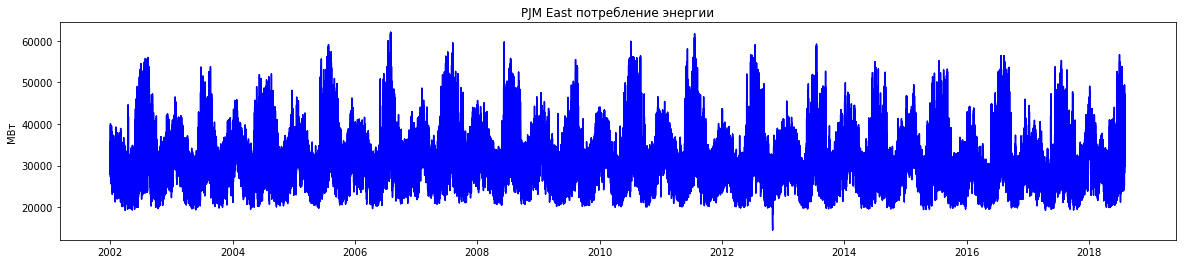

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
#Конвертируем данные в дневное потребление
d_data=data.resample('D').mean()

In [7]:
#Применим экспоненциальное сглаживание

data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)

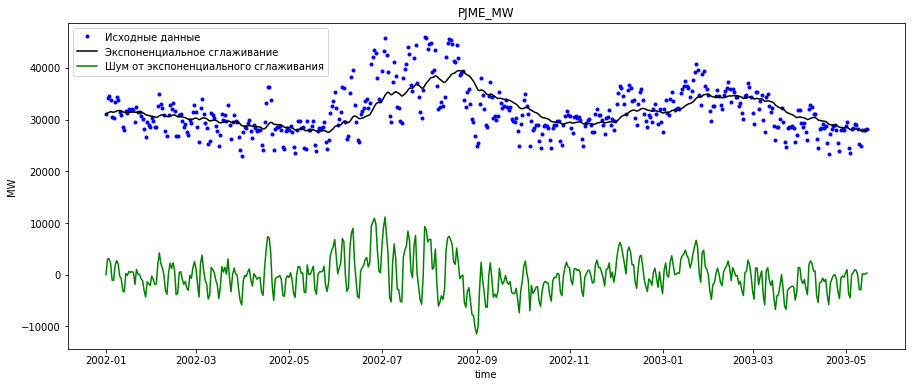

In [9]:
plt.figure(figsize=(15, 6))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], 
         '.b', label='Исходные данные')

plt.plot(d_data.index[:500], data_exp_1[:500], 
         color = 'black', label="Экспоненциальное сглаживание")

plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500] - data_exp_1[:500], 
         color = 'g', label="Шум от экспоненциального сглаживания")

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW');

#### Экспоненциальное сглаживание по дневному потреблению показала сезонность, которую удобно предсказывать. Получившийся "шум" тоже имеет явные закономерности, которые можно глубже исследовать и использовать.

In [11]:
#Запишем результат в датафрейм + добавим признаки

df= pd.DataFrame(data_exp_1, index=d_data.index)

 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)

# добавили сглаживание
df['exp_0_05'] = exponential_smoothing(df[0], 0.05)

# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[1:,0].values-df.iloc[:-1,0].values

df.head()

,0,t,t1,t2,exp_0_05,diff1
Date,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31088.691137,159.040127
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31104.425782,163.604787
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31125.153881,115.603714
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31142.060918,-55.693138


In [18]:
# Для учета только глубины истории 3, уберем t & t1
df3 = df.drop(['t', 't1'], axis=1)
df3.head()

,0,t2,exp_0_05,diff1
Date,,,,
2002-01-01,31080.739130,0.000000,31080.739130,0.000000
2002-01-02,31239.779257,0.000000,31088.691137,159.040127
2002-01-03,31403.384044,0.000000,31104.425782,163.604787
2002-01-04,31518.987759,31080.739130,31125.153881,115.603714
2002-01-05,31463.294621,31239.779257,31142.060918,-55.693138


In [19]:
train_b, test_b = split_data_b( df3, '2017-06-01')

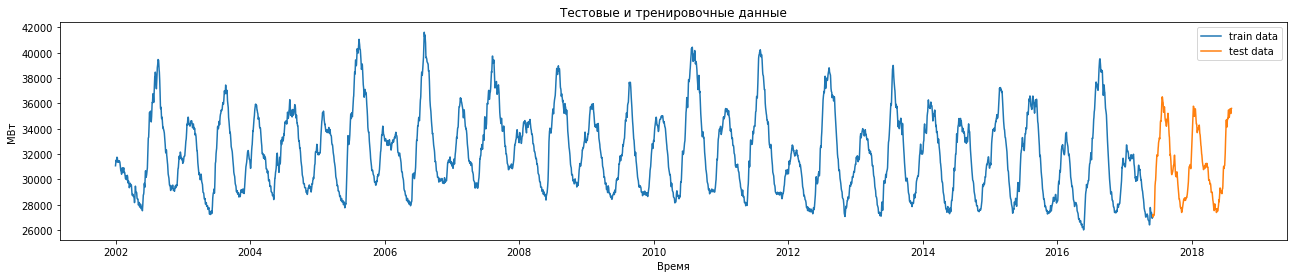

In [20]:
plt.figure( figsize=( 22, 4 ))
plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [21]:
#Запишем в функцию постороения прогноза в зависимости от глубины

def h_boost(h,train_b=train_b, test_b=test_b):
    X_train_b = train_b.iloc[:-h,:]
    y_train_b = train_b[df.columns[0]].values[h:]
    X_test_b = test_b.iloc[:-h,:]
    y_test_b = test_b[df.columns[0]].values[h:]
    
    model_gb = GradientBoostingRegressor(max_depth=12, random_state=0, n_estimators=100)
    model_gb.fit( X_train_b, y_train_b ) 
    X_test_pred_gb = model_gb.predict(X_test_b)
    
    
    plt.figure( figsize=( 22, 4 ))

    plt.xlabel('Время')
    plt.ylabel('МВт')
    plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
    plt.plot(test_b.index[h:],y_test_b, label='test data')

    plt.legend()
    plt.show()

    er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)
    print(f'Для глубины прогноза {h}')
    print(f'ошибка градиентного бустинга : {er_g:.3f} %')

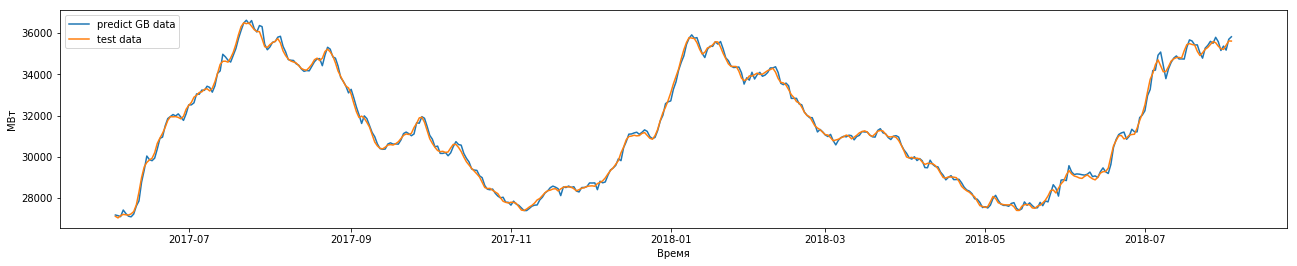

Для глубины прогноза 1
ошибка градиентного бустинга : 0.387 %


In [22]:
h_boost(1)

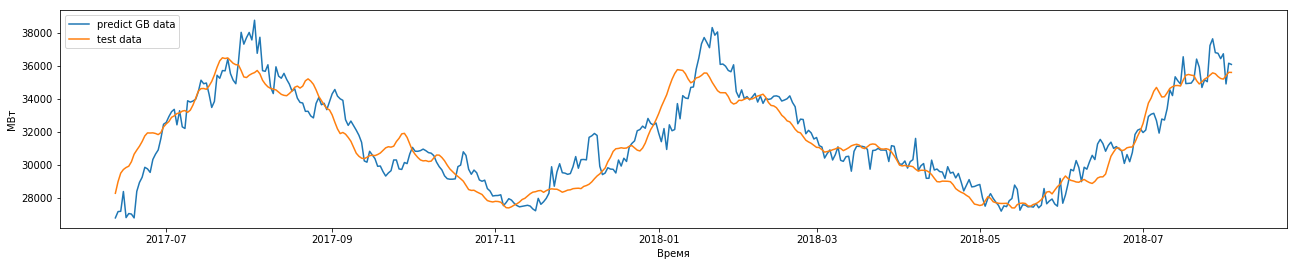

Для глубины прогноза 10
ошибка градиентного бустинга : 2.865 %


In [23]:
h_boost(10)

#### С увеличением глубины прогноза, ошибка значительно увеличилась.
#### Однако, ошибка в 2-3% для глубины 10 является приемлимой для большинства случаев. 
#### C другой стороны, перед нами очень хороший ряд. Хорошая сезонность, стабильные измерения. 
#### На практике, для прогноза продаж (на 12 мес вперед), я не смогла использовать данный алгоритм. В т.ч. и потому, что прогноз строится не на 1 ряд данных, а на 50 тыс рядов данных (500 групп прогноза * 100 локаций).


### Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

#### а) Изменение температуры за окном :).

#### б) Количество денег, которые тратят покупатели в интернет магазине.

#### в) Вес растущего котенка.

#### г) Прирост объема деревьев в лесу от времени


#### а) Не стационарен. На вековых промежутках - будет тренд (Например, поменялось течение и регион "остывает"). Выраженная сезонность и цикличность (движение планет - малые и большие циклы).
#### б) Зависит от отрасли и стадии жизненного цикла магазина. Для большинства не стационарен,с восходящим трендом (рынок еще перераспределяется в сторону интернет торговли, происходит насыщение); сезонность - для большинства да, особенно в странах с высокой климатической сезонностью; про циклы - думаю, есть, т.к. торговля зависит от поведения людей, а те цикличны.
#### в) Вес не стационарен - вес развивается по ln(x), Если кормить котенка по расписанию и по нормам, то будут наблюдаться почасовые циклы.
#### г) Прирост объема в % не стационарен - тоже имеет вид n(x), циклы и сезонность тоже есть (зима-лето, сезон дождей-нет: все влияет на скорость прироста).


### Какие из рядов на картинке стационарны на первый взгляд? (презентация, слайд номер 21)

#### Стационарны:  b,может, f и c.